<a href="https://colab.research.google.com/github/funteck123/SUSAR_AI_Framework_Insight_Classfication_with_LLM_Text_Gen_Model-Python/blob/main/Copy_of_SUSAR_AI_Framework_Insight_Classfication_with_LLM_Text_Gen_Model_v2%20Llama3.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SUSAR AI Framework - Insight Classfication with LLM Text Gen Model v2** 🧠📔


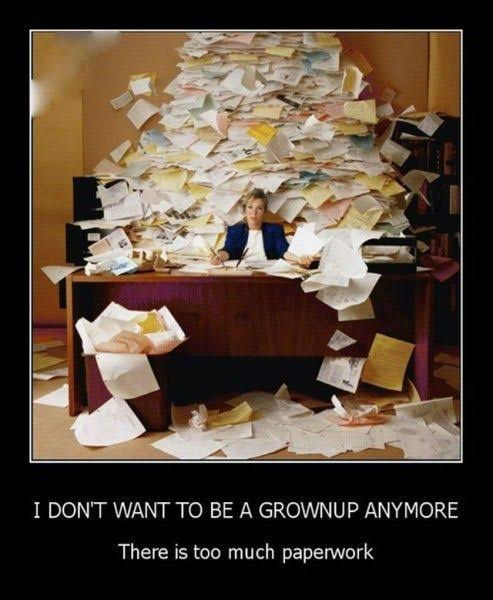


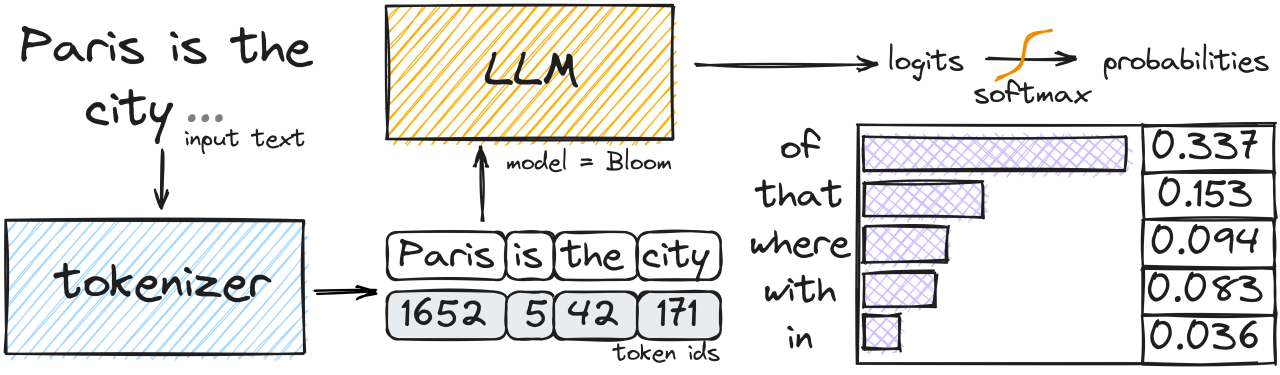

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline
import re
import torch

In [10]:
!sudo apt-get install -y pciutils
!curl -fsSL https://ollama.com/install.sh | sh # download ollama api
from IPython.display import clear_output

# Create a Python script to start the Ollama API server in a separate thread

import os
import threading
import subprocess
import requests
import json

def ollama():
    os.environ['OLLAMA_HOST'] = '0.0.0.0:11434'
    os.environ['OLLAMA_ORIGINS'] = '*'
    subprocess.Popen(["ollama", "serve"])

ollama_thread = threading.Thread(target=ollama)
ollama_thread.start()

from IPython.display import clear_output
!ollama pull llama3.1:8b
clear_output()

!pip install -U lightrag[ollama]

from lightrag.core.generator import Generator
from lightrag.core.component import Component
from lightrag.core.model_client import ModelClient
from lightrag.components.model_client import OllamaClient, GroqAPIClient

import time


qa_template = r"""<SYS>
You are a helpful assistant.
</SYS>
User: {{input_str}}
You:"""

class SimpleQA(Component):
    def __init__(self, model_client: ModelClient, model_kwargs: dict):
        super().__init__()
        self.generator = Generator(
            model_client=model_client,
            model_kwargs=model_kwargs,
            template=qa_template,
        )

    def call(self, input: dict) -> str:
        return self.generator.call({"input_str": str(input)})

    async def acall(self, input: dict) -> str:
        return await self.generator.acall({"input_str": str(input)})

from lightrag.components.model_client import OllamaClient
from IPython.display import Markdown, display
model = {
    "model_client": OllamaClient(),
    "model_kwargs": {"model": "llama3.1:8b"}
}


In [11]:
generator = SimpleQA(**model)
output=generator("what is happiness").data
display(Markdown(f"**Answer:** {output}"))

**Answer:** What a wonderful topic!

Happiness is a state of well-being, joy, and contentment that comes from within. It's a subjective experience that can be defined differently by each person, but some common threads include:

* A sense of fulfillment and satisfaction with life
* Positive emotions such as joy, love, and excitement
* A feeling of being in the present moment, without worries or regrets about the past or future
* A connection to one's values, passions, and goals
* A sense of gratitude and appreciation for what one has

Happiness can be found in everyday moments, like:

* Laughing with loved ones
* Enjoying a beautiful sunset
* Trying new experiences and learning something new
* Giving back to others through acts of kindness and generosity
* Practicing self-care and taking care of oneself

What does happiness mean to you?

In [12]:
# Patient Outcomes
patient_outcome_texts = [
    "The patient's clinical status shows incremental improvement with stable vital signs; however, full recovery remains elusive as evidenced by residual chronic symptoms and ongoing need for symptomatic treatment.",
    "Despite progressive therapeutic interventions, the patient exhibits persistent adverse reactions and secondary complications that impede recovery, necessitating advanced management strategies.",
    "Following an initial positive response to therapy, the patient has reached a plateau in health status with complete resolution of acute symptoms but ongoing subclinical indicators suggesting the necessity for prolonged observation.",
    "The patient's health trajectory demonstrates significant amelioration with the resolution of major disease symptoms, although minor residual effects warrant continued follow-up to confirm sustained recovery." ,
    "The patient's condition, initially responsive to treatment, has deteriorated leading to multi-organ failure, resulting in a deadly outcome."
]

# Correct outputs corresponding to the texts
patient_outcome_labels = [
    "Recovering",               # Incremental improvement but full recovery remains elusive
    "Not Recovering",  # Persistent adverse reactions and secondary complications impede recovery
    "Recovering",               # Plateau in health status with ongoing subclinical indicators
    "Recovering",               # Significant amelioration with resolution of major symptoms, minor residual effects
    "Fatal"                    # Deterioration leading to multi-organ failure and a deadly outcome
]


# Drug Actions
drug_action_texts = [
    "The dosage of the current medication was maintained following an assessment indicating stable clinical progress and minimal adverse events. Future evaluations will continue to monitor the necessity of any further dosage adjustments based on patient response.",
    "The patient's recent adverse events are attributable to excessive drug exposure, prompting a dose reduction to mitigate toxicity while maintaining therapeutic benefits.",
    "Current therapeutic levels have stabilized the patient's condition; hence, no modification to the dosage is required as the medication remains within the therapeutic window.",
    "Due to the onset of severe side effects consistent with drug overdose, the medication regimen has been temporarily halted pending reassessment and dose adjustment.",
    "Emerging evidence from recent trials supports an escalation of the drug dosage to enhance therapeutic outcomes, with close monitoring for potential adverse effects during the increased dosage phase."
]

drug_action_labels = [
    "Same Dose",
    "Decrease",
    "Same Dose",
    "Stop",
    "Increase"
]

# Causalities
causality_texts = [
    "Analysis of the patient's symptomatology indicates that the observed side effects are consistent with known adverse reactions to the current medication, suggesting a direct causal relationship.",
    "The patient's clinical presentation correlates with a new, unrelated health condition, with no evidence linking the symptoms to the ongoing pharmacological treatment.",
    "The documented adverse effects are attributable to an interaction between the drug and an external factor, rather than a direct consequence of the medication itself.",
    "In-depth diagnostic evaluations reveal that the recent health complications are a direct result of the pharmacological intervention, corroborating a causative link between the drug and the symptoms.",
    "The occurrence of unexpected side effects aligns with a known complication profile for the drug, indicating that the medication is likely the primary factor contributing to the patient's symptoms."
]

causality_labels = [
    "Related",
    "Not Related",
    "Not Related",
    "Related",
    "Related"
]


In [13]:
import requests
import re

# Normalization functions
def normalize_text(text):
    if text is not None:
        return re.sub(r'\s+', ' ', text.strip().lower())
    return text

def normalize_text_array(text_array):
    for i in range(len(text_array)):
        text_array[i] = normalize_text(text_array[i])
    return text_array

# Initialize global variables for predictions
patient_outcomes_pred = []
drug_actions_pred = []
causalities_pred = []

# Function to extract the label from the generated text
def extract_label(generated_text, labels):
    for label in labels:
        if label.lower() in generated_text.lower():
            return label
    return None

# Evaluation functions
def evaluate_patient_outcomes(texts, correct_outputs):
    labels = normalize_text_array(["Not Recovering", "Recovering", "Recovering with Complications", "Recovered", "Fatal"])
    correct_predictions = 0
    total = len(texts)

    for i, text in enumerate(texts):
        prompt = f"""
        You are provided with a detailed description of a patient's current health status. Your task is to accurately classify the patient's health status into one of the following specific categories based on the description:

        - Not Recovering: The patient shows no signs of improvement and is not progressing towards recovery.
        - Recovering: The patient is showing signs of improvement but has not yet fully recovered to a normal health state.
        - Recovering with Complications: The patient is in the process of recovery but is experiencing additional complications or health issues.
        - Recovered: The patient has fully recovered and returned to their normal state of health with negligible ongoing issues.
        - Fatal: The patient has passed away due to the condition or treatment.

        Carefully read the following description of the patient's health status and provide the most appropriate label from the options: [Not Recovering, Recovering, Recovering with Complications, Recovered, Fatal]

        Description: {text}

        Label:
        """
        result = generator(prompt).data
        generated_text = extract_label(normalize_text(result), labels)
        patient_outcomes_pred.append(generated_text)

        correct_output = normalize_text(correct_outputs[i])
        if normalize_text(generated_text) == correct_output:
            correct_predictions += 1
        else:
            print(f"Patient Outcome Text: {text}")
            print(f"Generated Text: {generated_text}")
            print(f"Correct Output: {correct_output}")
            print()

    accuracy = (correct_predictions / total) * 100
    return accuracy

def evaluate_drug_actions(texts, correct_outputs):
    labels = normalize_text_array(["Same Dose", "Stop", "Increase", "Decrease"])
    correct_predictions = 0
    total = len(texts)

    for i, text in enumerate(texts):
        prompt = f"""
        You are provided with a description of a patient's reaction to a drug. Based on this description, identify the most appropriate action to take regarding the dosage of the drug. Choose only one of the following options:

        - Same Dose: Continue with the current dosage of the drug.
        - Stop: Discontinue the drug.
        - Increase: Increase the dosage of the drug.
        - Decrease: Decrease the dosage of the drug.

        Carefully read the following description and provide the most appropriate action label from the options: [Same Dose, Stop, Increase, Decrease]

        Description: {text}

        Label:
        """
        result = generator(prompt).data
        generated_text = extract_label(normalize_text(result), labels)
        drug_actions_pred.append(generated_text)

        correct_output = normalize_text(correct_outputs[i])
        if generated_text == correct_output:
            correct_predictions += 1
        else:
            print(f"Drug Action Text: {text}")
            print(f"Generated Text: {generated_text}")
            print(f"Correct Output: {correct_output}")
            print()

    accuracy = (correct_predictions / total) * 100
    return accuracy

def evaluate_causalities(texts, correct_outputs):
    labels = normalize_text_array(["Related", "Not Related"])
    correct_predictions = 0
    total = len(texts)

    for i, text in enumerate(texts):
        prompt = f"""
        You are provided with a description of symptoms or issues experienced by a patient. Your task is to determine if these symptoms or issues are related to the drug treatment or not. Choose one of the following options:

        - Related: The symptoms or issues are connected to the drug or treatment.
        - Not Related: The symptoms or issues are not connected to the drug or treatment and may be due to other factors.

        Carefully read the following description and provide the most appropriate causality label from the options: [Related, Not Related]

        Description: {text}

        Label:
        """
        result = generator(prompt).data
        generated_text = extract_label(normalize_text(result), labels)
        causalities_pred.append(generated_text)

        correct_output = normalize_text(correct_outputs[i])
        if generated_text == correct_output:
            correct_predictions += 1
        else:
            print(f"Causality Text: {text}")
            print(f"Generated Text: {generated_text}")
            print(f"Correct Output: {correct_output}")
            print()

    accuracy = (correct_predictions / total) * 100
    return accuracy


In [14]:
# Evaluate the model
patient_outcome_accuracy = evaluate_patient_outcomes(patient_outcome_texts, patient_outcome_labels)
print(f"Patient Outcome Accuracy: {patient_outcome_accuracy:.2f}%")

drug_action_accuracy = evaluate_drug_actions(drug_action_texts, drug_action_labels)
print(f"Drug Action Accuracy: {drug_action_accuracy:.2f}%")

causality_accuracy = evaluate_causalities(causality_texts, causality_labels)
print(f"Causality Accuracy: {causality_accuracy:.2f}%")

Patient Outcome Text: Despite progressive therapeutic interventions, the patient exhibits persistent adverse reactions and secondary complications that impede recovery, necessitating advanced management strategies.
Generated Text: recovering
Correct Output: not recovering

Patient Outcome Text: The patient's health trajectory demonstrates significant amelioration with the resolution of major disease symptoms, although minor residual effects warrant continued follow-up to confirm sustained recovery.
Generated Text: recovered
Correct Output: recovering

Patient Outcome Accuracy: 60.00%
Drug Action Text: Emerging evidence from recent trials supports an escalation of the drug dosage to enhance therapeutic outcomes, with close monitoring for potential adverse effects during the increased dosage phase.
Generated Text: decrease
Correct Output: increase

Drug Action Accuracy: 80.00%
Causality Text: The patient's clinical presentation correlates with a new, unrelated health condition, with no e

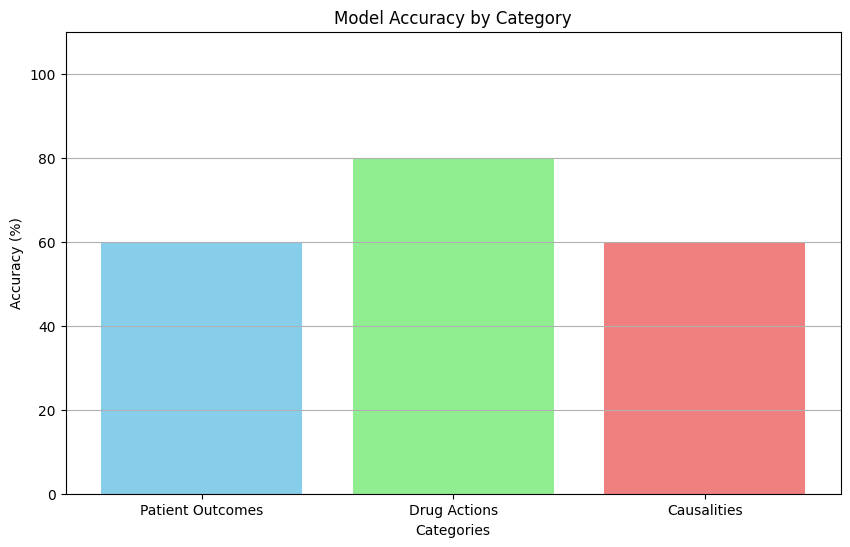

In [15]:
import matplotlib.pyplot as plt

# Accuracy data
categories = ['Patient Outcomes', 'Drug Actions', 'Causalities']
accuracies = [patient_outcome_accuracy, drug_action_accuracy, causality_accuracy]  # Replace with actual accuracy values if different

# Plot
plt.figure(figsize=(10, 6))
plt.bar(categories, accuracies, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.xlabel('Categories')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy by Category')
plt.ylim(0, 110)
plt.grid(axis='y')
plt.show()


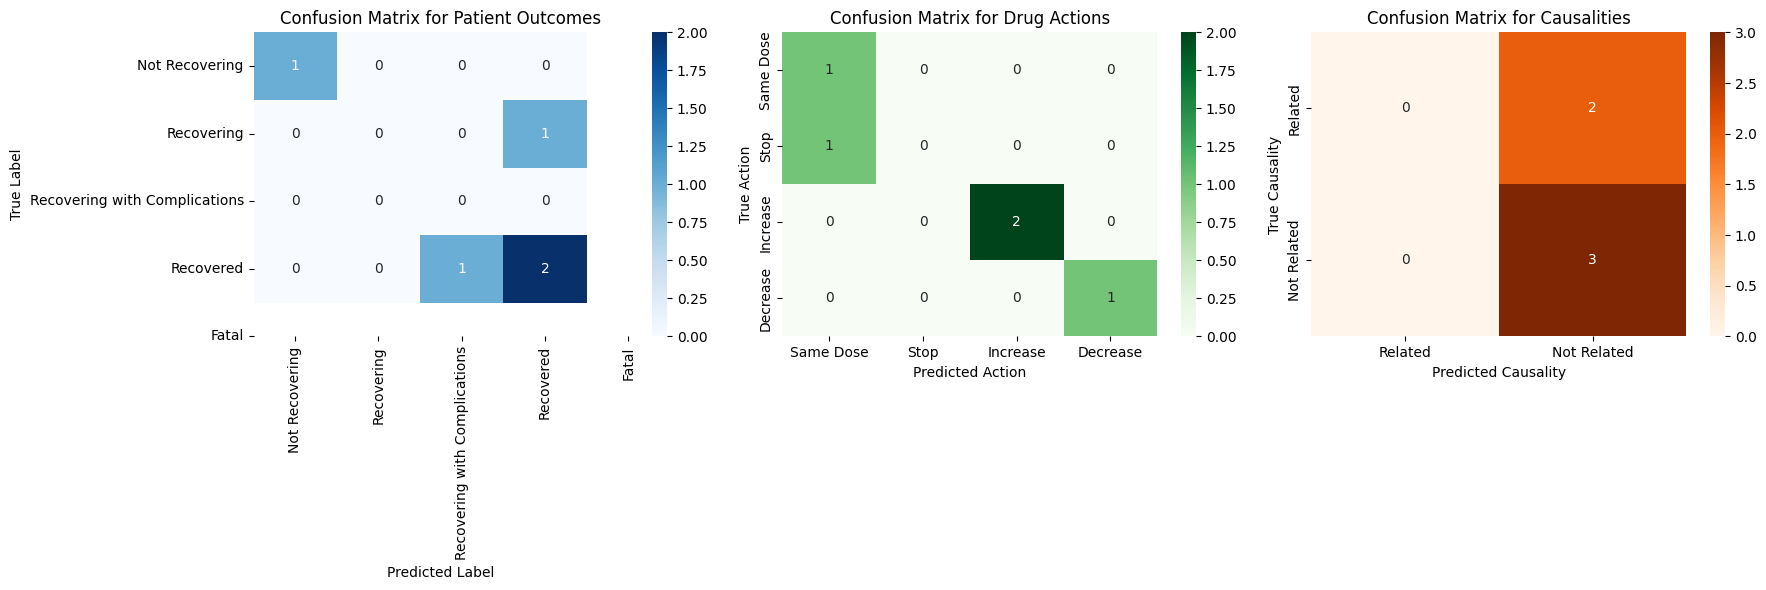

In [16]:
patient_outcome_labels = normalize_text_array(patient_outcome_labels)


drug_action_labels = normalize_text_array(drug_action_labels)


causality_labels = normalize_text_array(causality_labels)

# Compute confusion matrices
conf_matrix_patient_outcomes = confusion_matrix(patient_outcome_labels, patient_outcomes_pred)
conf_matrix_drug_actions = confusion_matrix(drug_action_labels, drug_actions_pred)
conf_matrix_causalities = confusion_matrix(causality_labels, causalities_pred)

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot confusion matrix for Patient Outcomes
sns.heatmap(conf_matrix_patient_outcomes, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Recovering', 'Recovering', 'Recovering with Complications', 'Recovered', 'Fatal'],
            yticklabels=['Not Recovering', 'Recovering', 'Recovering with Complications', 'Recovered', 'Fatal'],
            ax=axs[0])
axs[0].set_title('Confusion Matrix for Patient Outcomes')
axs[0].set_xlabel('Predicted Label')
axs[0].set_ylabel('True Label')

# Plot confusion matrix for Drug Actions
sns.heatmap(conf_matrix_drug_actions, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Same Dose', 'Stop', 'Increase', 'Decrease'],
            yticklabels=['Same Dose', 'Stop', 'Increase', 'Decrease'],
            ax=axs[1])
axs[1].set_title('Confusion Matrix for Drug Actions')
axs[1].set_xlabel('Predicted Action')
axs[1].set_ylabel('True Action')

# Plot confusion matrix for Causalities
sns.heatmap(conf_matrix_causalities, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Related', 'Not Related'],
            yticklabels=['Related', 'Not Related'],
            ax=axs[2])
axs[2].set_title('Confusion Matrix for Causalities')
axs[2].set_xlabel('Predicted Causality')
axs[2].set_ylabel('True Causality')

# Adjust layout
plt.tight_layout()
plt.show()


# print("Confusion Matrix for Patient Outcomes:")
# print(conf_matrix_patient_outcomes)
# print("\nConfusion Matrix for Drug Actions:")
# print(conf_matrix_drug_actions)
# print("\nConfusion Matrix for Causalities:")
# print(conf_matrix_causalities)




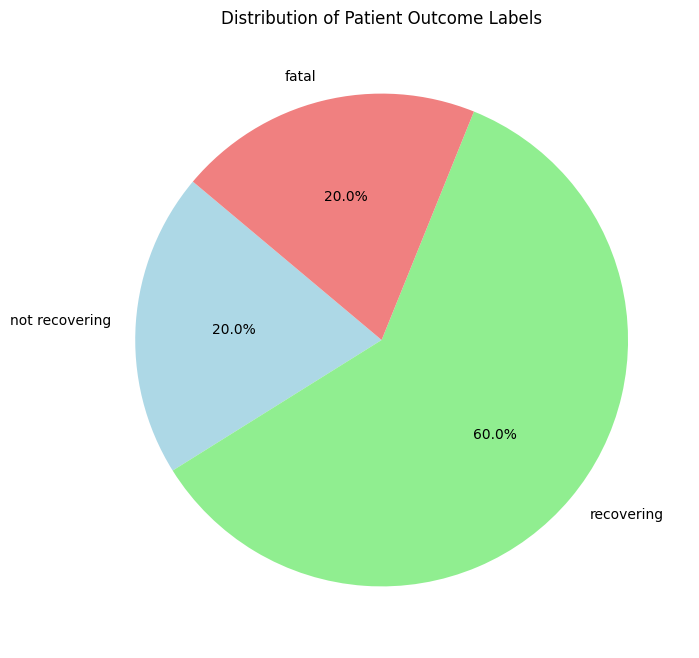

In [17]:
# Generate pie chart for Patient Outcomes
outcome_counts = [patient_outcome_labels.count(label) for label in normalize_text_array(['Not Recovering', 'Recovering', 'Recovering with Complications', 'Recovered', 'Fatal'])]
filtered_labels = [label for label, count in zip(normalize_text_array(['Not Recovering', 'Recovering', 'Recovering with Complications', 'Recovered', 'Fatal']), outcome_counts) if count > 0]
filtered_counts = [count for count in outcome_counts if count > 0]

plt.figure(figsize=(8, 8))
plt.pie(filtered_counts, labels=filtered_labels, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightgreen', 'lightcoral', 'salmon', 'gold'])
plt.title('Distribution of Patient Outcome Labels')
plt.show()